# Stroke Prediction
The project inspects Stroke Prediction Dataset from Kaggle. 

The primary objectives are to clean the data, perform exploratory data analysis, statistical analysis, and apply various machine learning models for target variable Stroke prediction. Stroke prediction model must be calibrated for saving patient lives, as well as saving hospital time. 

## Dataset
Dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).


In [48]:
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.plotting.register_matplotlib_converters()
%matplotlib inline

%load_ext autoreload
%autoreload 2
from help_tool import help_tool


"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('rocket')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data download and Cleaning
Checking for duplicates and empty values, as well as the size of dataset.

In [49]:
stroke_prediction = help_tool.csv_download(
    r"..\Stroke_Prediction\archive\healthcare-dataset-stroke-data.csv")
stroke_prediction.head()

,Id,Gender,Age,Hypertension,Heart_disease,Ever_married,Work_type,Residence_type,Avg_glucose_level,Bmi,Smoking_status,Stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [50]:
help_tool.first_look(stroke_prediction)

Column data types:
Id                     int64
Gender                object
Age                  float64
Hypertension           int64
Heart_disease          int64
Ever_married          object
Work_type             object
Residence_type        object
Avg_glucose_level    float64
Bmi                  float64
Smoking_status        object
Stroke                 int64
dtype: object

Dataset has 5110 observations and 12 features
Columns with NULL values: ['Bmi']
Dataset has 0 duplicates


* Dataset has 5110 observations and 12 features. Null values are in columns 'Bmi' (201 instances), no duplicates. 

In [51]:
stroke_prediction[stroke_prediction['Bmi'].isnull()].shape

(201, 12)

Notating missing values with new columns

In [52]:
stroke_prediction['Bmi_was_missing'] = stroke_prediction['Bmi'].isnull().astype(int)

* Features have the expected datatypes, except age (which will be converted to integer)

In [53]:
stroke_prediction['Age'] = stroke_prediction['Age'].astype(int)

Age, Avg_glucose_level and BMI are continues features, while the rest are categorical

In [54]:
continues_features = ['Age', 'Avg_glucose_level', 'Bmi']
category_features = ['Gender', 'Hypertension', 'Heart_disease',
                     'Ever_married', 'Work_type', 'Residence_type', 
                     'Smoking_status', 'Stroke'
                     ]

In [55]:
stroke_data = stroke_prediction.copy()
stroke_data.drop(columns=['Id'], inplace=True)

## Continues features
Adults and children (up to 18 years old) have different ranking of BMI (Body Mass index). 
* [Children](https://dryatendrayadav.com/wp-content/uploads/2018/10/Sample-BMI-interpretation.jpg) BMI is generally lower than adults and safe BMI is represented by a parable. Healthy BMI by 10 years old is between 14 and 18.
* [Adults](https://blog.skinnyfit.com/wp-content/uploads/2021/01/shutterstock_1610175649-2048x2048.jpg) BMI is a constant - BMI between 19 AND 25 is denoted as safe. 

Due to children having different heath parameter levels than adults, data on < 18 years old will not be used. Target feature 'Stroke' has 2 rows for Children and model will not suffer.

In [56]:
stroke_data[(stroke_data['Age'] < 18) & (stroke_data['Stroke'] == 1)]

,Gender,Age,Hypertension,Heart_disease,Ever_married,Work_type,Residence_type,Avg_glucose_level,Bmi,Smoking_status,Stroke,Bmi_was_missing
162,Female,1,0,0,No,children,Urban,70.37,NaN,Unknown,1,1
245,Female,14,0,0,No,children,Rural,57.93,30.9,Unknown,1,0


Children and teens make up 856/5110 instances, dropping these rows will be beneficial to the 'Stroke' model as comparing children and adults health parameters is like comparring pears and apples.

In [57]:
stroke_data[(stroke_data['Age'] < 18)].shape

(856, 12)

In [58]:
# Dropping 'Age' < 18
stroke_data = stroke_data[stroke_data['Age'] >= 18]

### Continues feature distribution
#### Target demographic
Looking closer at continues feature distribution, it can be seen that this research mainly focused on people:
* Middle aged
* Healthy (BMI and Avg_glucose_level are on the healthy norm)

Age


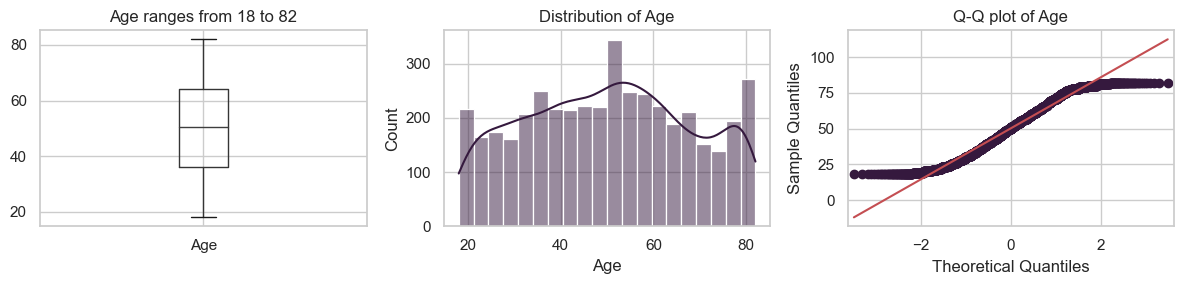

Avg_glucose_level


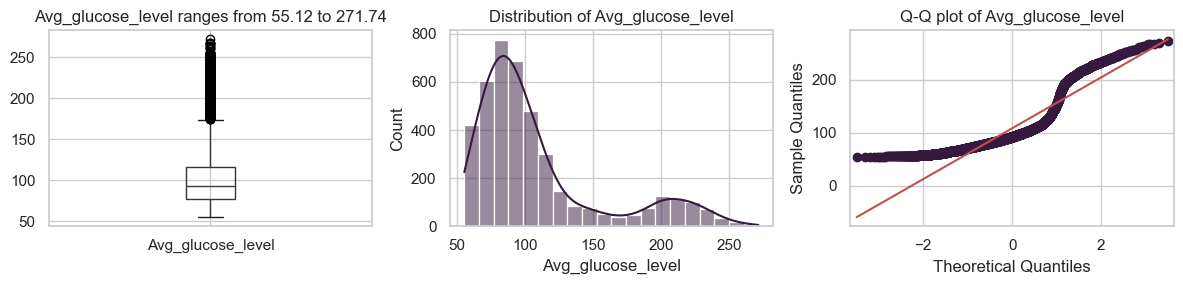

Bmi


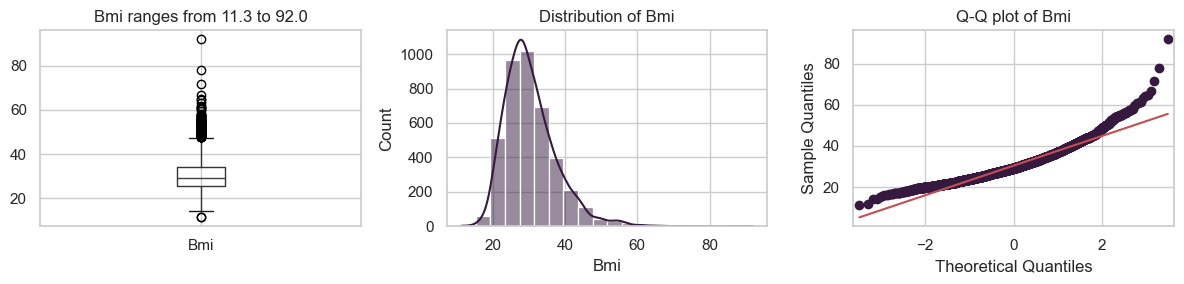

In [59]:
help_tool.distribution_check(stroke_data[continues_features])

Age, Avg_glucose_level and Bmi are non normally distributed - skewed to the right
* Age has the no outliers
* Avg_glucose_level is mostly around 50-100 (mg/dL), but it can go up above 240 (mg/dL) which signals dangerous glucose levels and medical attention would be needed due to [Hyperglycemia](https://www.mayoclinic.org/diseases-conditions/hyperglycemia/symptoms-causes/syc-20373631).

* BMI reaches up to 92, according to [Wikipedia](https://en.wikipedia.org/wiki/List_of_heaviest_people), people can survive having 251 BMI . 

Outliers will be left in.

Checking dependencies of continues features with one another.

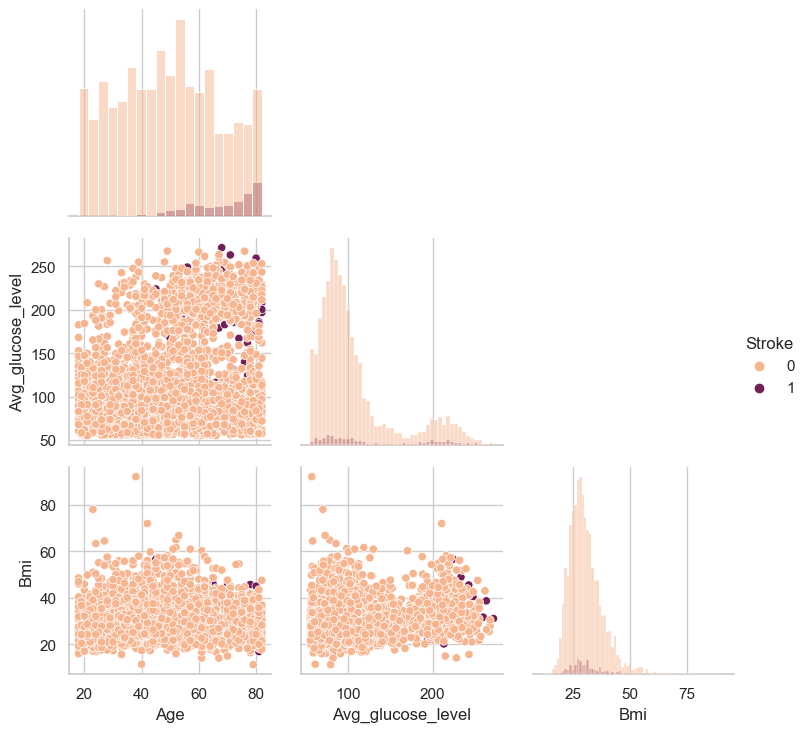

In [60]:
g = sns.PairGrid(stroke_data[continues_features+['Stroke']],
                 hue='Stroke',
                 diag_sharey=False, corner=True,
                 palette={1: 'C1', 0: 'C5'}
                 )
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

plt.show()

What about missing BMI?

Null Hypothesis: Bmi_was_missing is seen in any Avg_glucose_level group.<br>
Alternative Hypotheses: Bmi_was_missing depends on sertain Avg_glucose_level group.

In [61]:
for feature in ['Bmi_was_missing']:
    help_tool.significance_t_test(stroke_data, 'Avg_glucose_level', feature, 0, 1)

p-value = 0.0000 between Avg_glucose_level and Bmi_was_missing. Reject null hypothesis


Are there difference in Avg_glucose_level Confidence Interval (95%) when BMI is missing?

In [62]:
print('Missing: ')
help_tool.confidence_intervals(
    stroke_data[stroke_data['Bmi_was_missing'] == 1]['Avg_glucose_level'], 'Continuous')
print('Not missing: ')
help_tool.confidence_intervals(
    stroke_data[stroke_data['Bmi_was_missing'] == 0]['Avg_glucose_level'], 'Continuous')

Missing: 
Confidence Interval: [120.08, 137.63]
Not missing: 
Confidence Interval: [106.17, 109.05]


BMI is missing happens when Avg_glucose_level are on the higher scale (towards the dangerous levels)

Visual inspection showed continues features doesn't have linear relationships. Avg_glucose_level and BMI are not related to Age.

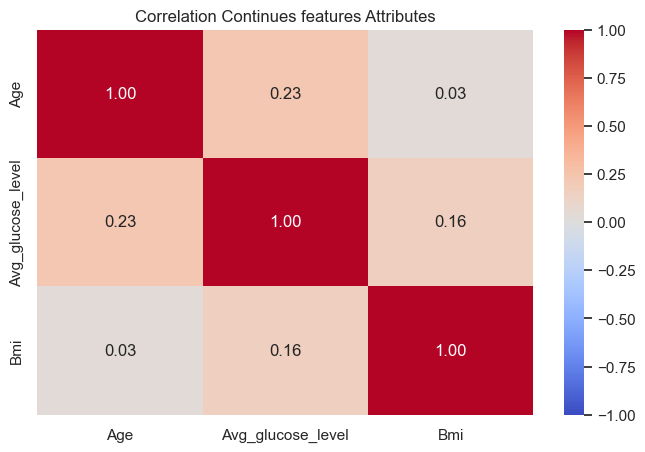

In [63]:
help_tool.heatmap(stroke_data[continues_features],
                  'Continues Features', 'pearson')

* Pearson coefficients also show Continues features are not linearly correlated.

BMI has missing values when Avg_glucose_level are on the higher scale (towards the dangerous levels). 
* This could be due to BMI maximum value being 3 digits, but only 2 digits are available in this data. 
* Until model is created, it can't be said for sertain that 3 digits is the problem

Imputation  will be done at the last step of EDA, with not changing current BMI distribution (in case 3 digit theory is wrong).

## Categorical features
Let's examine the distribution of categorical features

#### Target demographic
Looking closer at categorical feature distribution, it can be seen that this research mainly focused on people:
* Married
* Female
* Works for Private companies
* Healthy (no stroke, hypertension or heart disease)

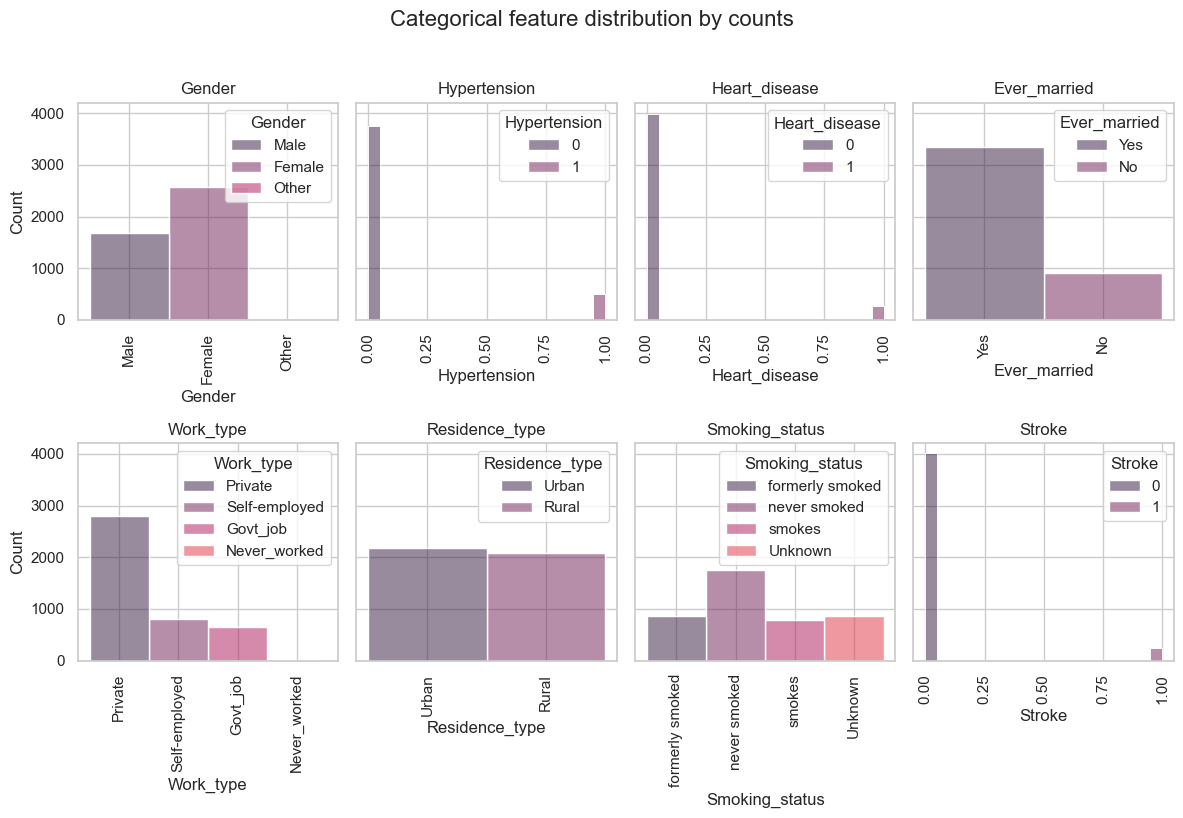

In [64]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8), sharey=True)

axes = axes.flatten()

for i, col in enumerate(category_features):
    sns.histplot(data=stroke_data, x=col, kde=True, bins=20,
                 ax=axes[i], hue=col, legend=True)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

* Target feature 'Stroke' is imbalanced, where '0' value is dominant.
* Binary answers (Yes/No) answers will be converted to binary features ('Gender', 'Ever_married', 'Residence_type').
* 'Work_type' and 'Smoking_status' will be examined further.

* 'Gender' has 1 value outside Male/Female where target feature has dominant value - 1 row will be dropped as it won't significantly contribute to the model.

In [65]:
stroke_prediction[stroke_prediction['Gender'] == 'Other'][['Gender', 'Stroke']]

,Gender,Stroke
3116,Other,0


In [66]:
# Dropping 'Gender' = 'Other'
stroke_data = stroke_data[stroke_data['Gender'] != 'Other']


# Converting Binary answer features to 1/0
stroke_data = help_tool.dummy_columns(
    stroke_data, ['Gender', 'Ever_married', 'Residence_type'])
stroke_data.rename(
    columns={'Residence_type_Urban': 'Residence_Urban'}, inplace=True)
stroke_data.drop(columns=['Gender_Male', 'Residence_type_Rural'], inplace=True)

### 'Work_type' Never Worked
Never worked individuals have 5 rows and all represent young people not yet entered to work force. These rows will be dropped as to reduce the upcoming model dimensionality.

In [67]:
stroke_data[stroke_data['Work_type'] == 'Never_worked']

,Age,Hypertension,Heart_disease,Work_type,Avg_glucose_level,Bmi,Smoking_status,Stroke,Bmi_was_missing,Gender_Female,Ever_married,Residence_Urban
603,23,0,0,Never_worked,125.26,18.7,never smoked,0,0,0,0,1
886,19,0,0,Never_worked,86.96,25.8,never smoked,0,0,1,0,1
2917,18,0,0,Never_worked,82.36,22.7,Unknown,0,0,1,0,1
4160,18,0,0,Never_worked,81.73,21.6,never smoked,0,0,1,0,1
4772,18,0,0,Never_worked,97.65,21.5,Unknown,0,0,1,0,1


In [68]:
# Dropping 'Never worked'
stroke_data = stroke_data[stroke_data['Work_type'] != 'Never_worked']
stroke_data.shape

(4248, 12)

### Categorical feature distribution
Examining each binary variable to be a subset of another binary variable. I.e. Cat and Animal.

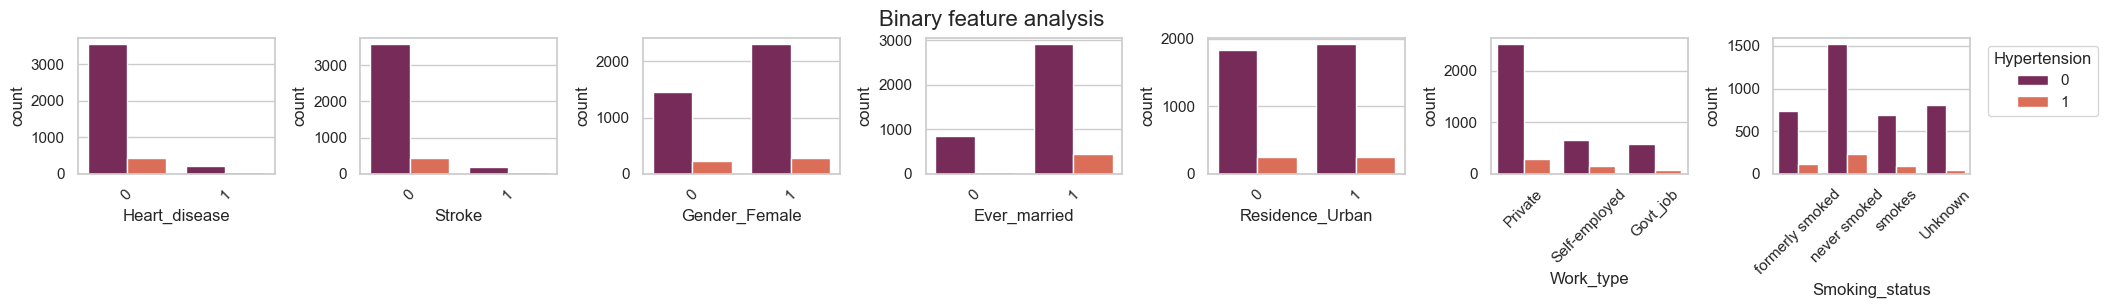

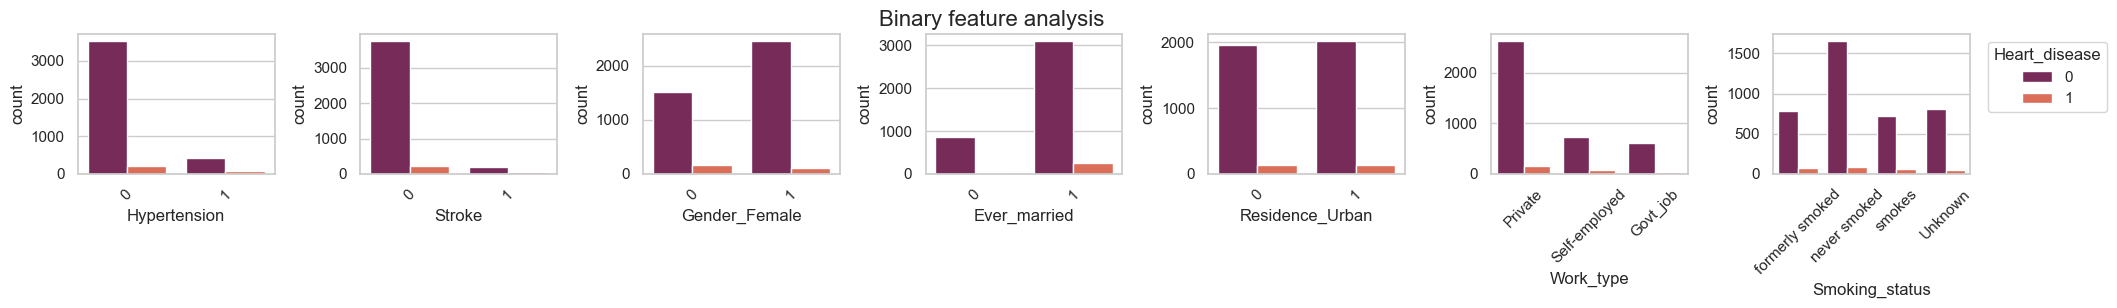

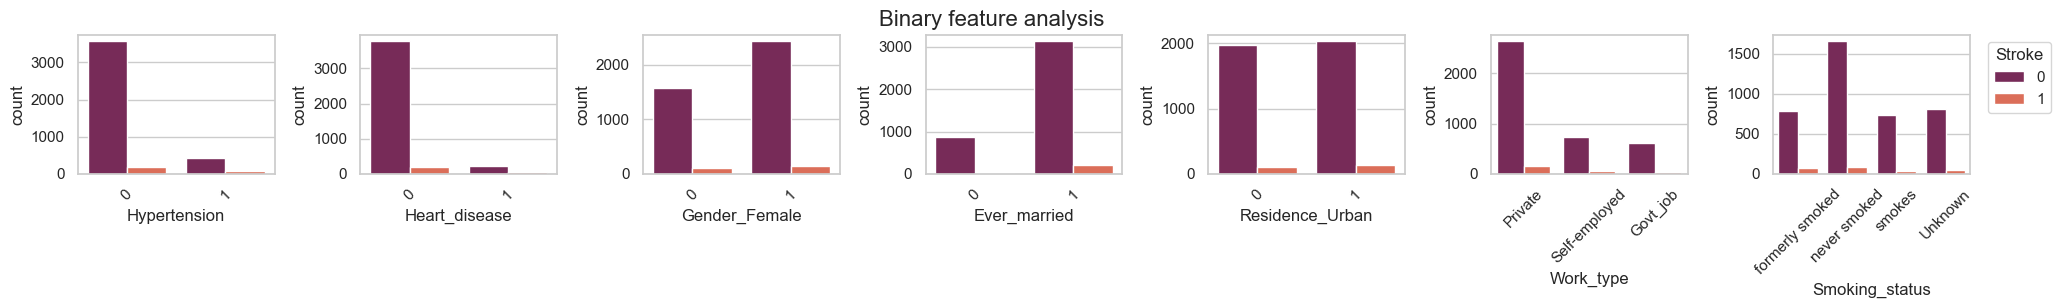

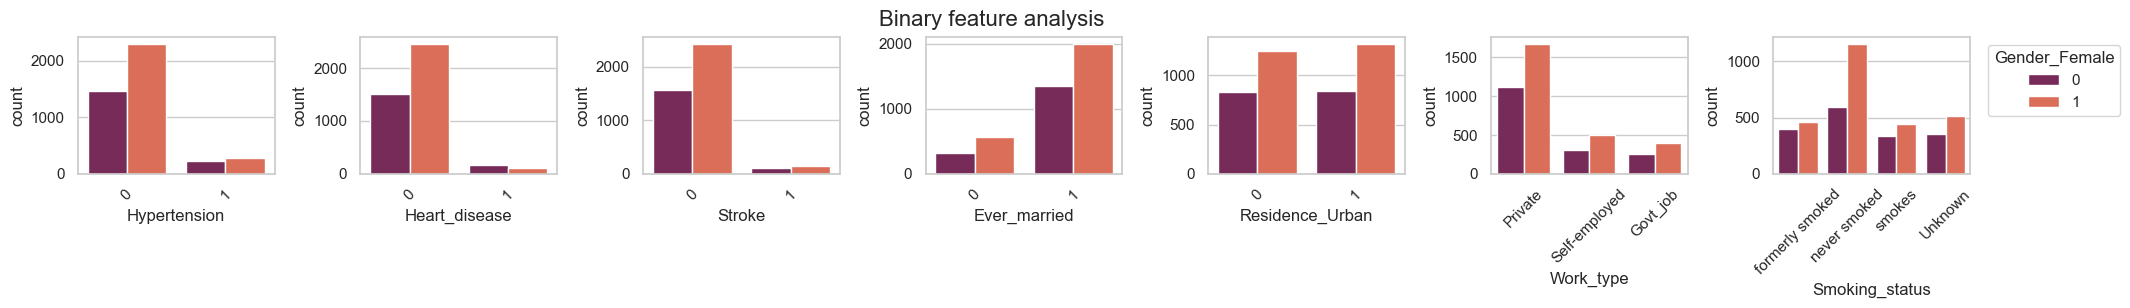

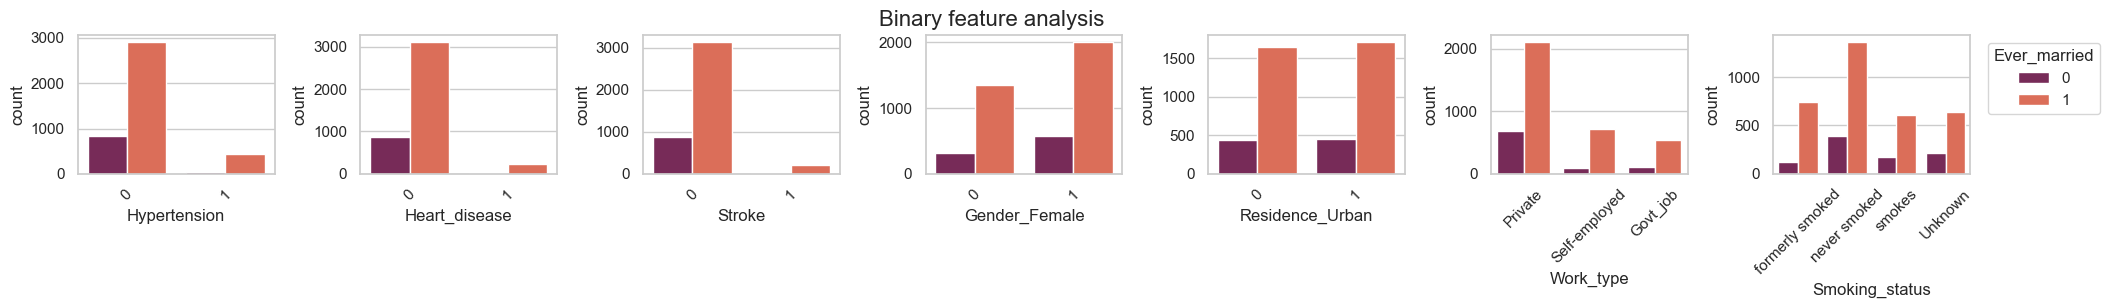

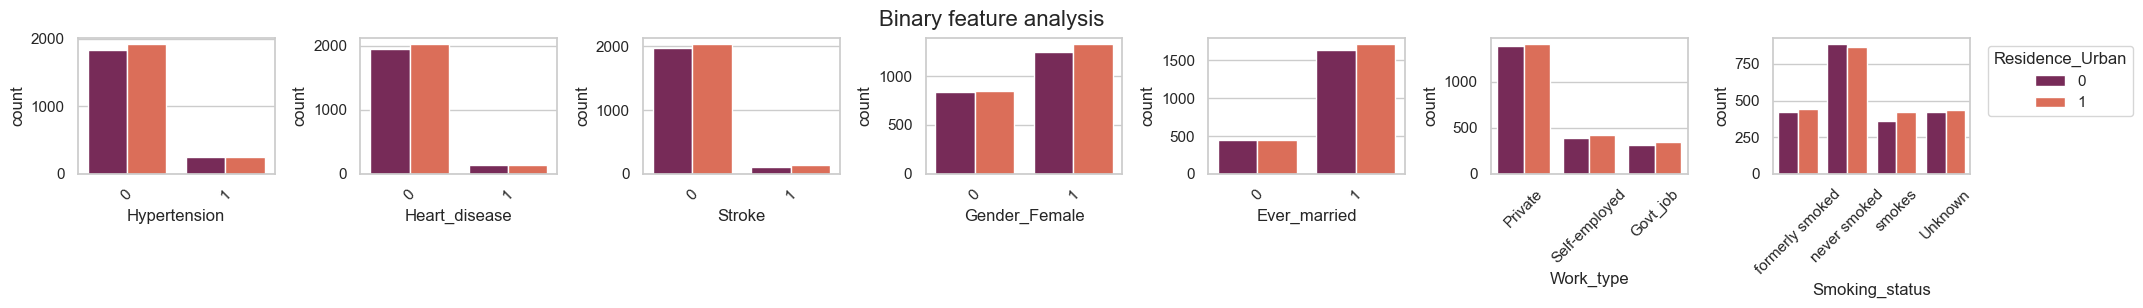

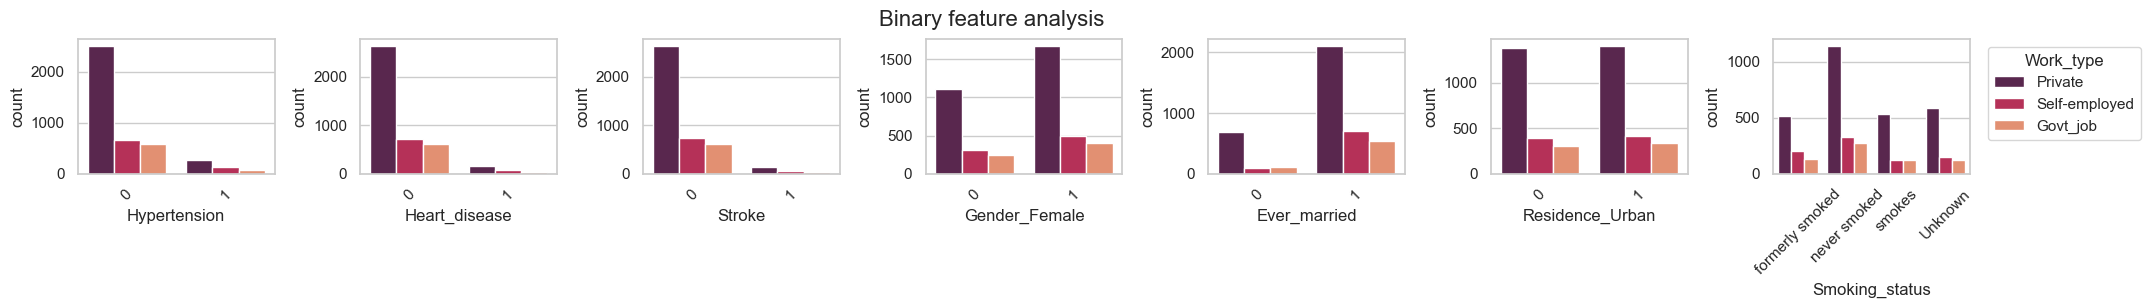

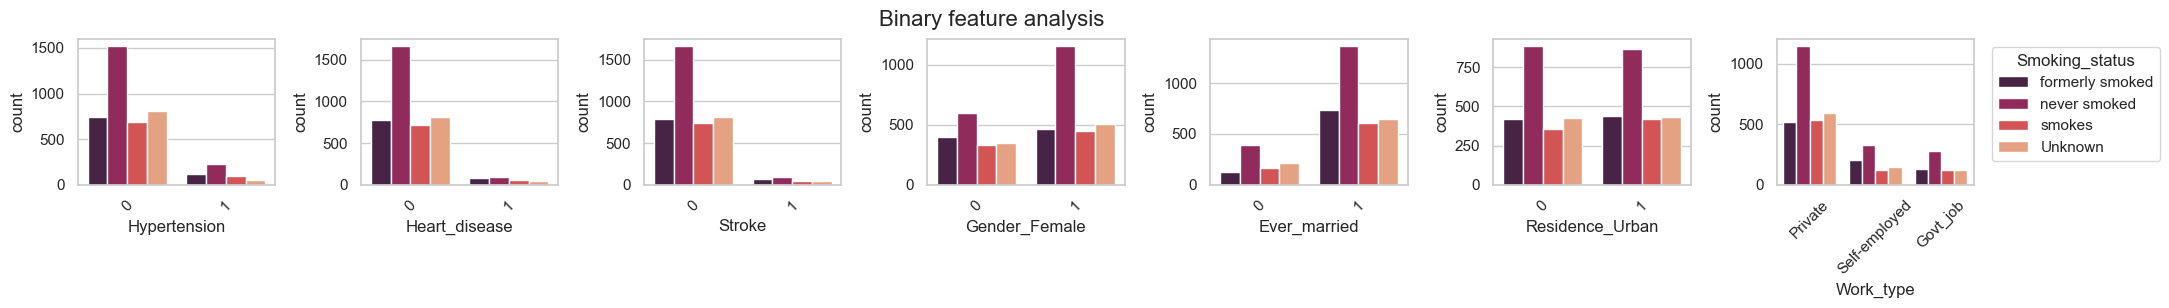

In [69]:
binary_features = ['Hypertension', 'Heart_disease', 'Stroke',
                   'Gender_Female', 'Ever_married', 'Residence_Urban']

help_tool.countplot_per_feature(
    stroke_data, binary_features+['Work_type', 'Smoking_status'])

Ever_married stands out, it seams that never have been married have some dependency on never getting Heart_disease and Stroke. Another interpretation could be that young people are not married and diseases take up the body later in life.

In [70]:
print('Married: ')
help_tool.confidence_intervals(
    stroke_data[stroke_data['Ever_married'] == 1]['Age'], 'Continuous')
print('Never Married: ')
help_tool.confidence_intervals(
    stroke_data[stroke_data['Ever_married'] == 0]['Age'], 'Continuous')

Married: 
Confidence Interval: [53.82, 54.87]
Never Married: 
Confidence Interval: [33.75, 36.03]


Confidence intervals of 95% suggests that being married is a function of age. 

Null Hypothesis: Stroke and Heart_disease happens to any Age group.<br>
Alternative Hypotheses: Stroke and Heart_disease happening depends on Age groups.

In [71]:
for feature in ['Stroke', 'Heart_disease']:
    help_tool.significance_t_test(stroke_data, 'Age', feature, 0, 1)

p-value = 0.0000 between Age and Stroke. Reject null hypothesis
p-value = 0.0000 between Age and Heart_disease. Reject null hypothesis


In [72]:
print('Stroke: ')
help_tool.confidence_intervals(
    stroke_data[stroke_data['Stroke'] == 1]['Age'], 'Continuous')
print('No Stroke: ')
help_tool.confidence_intervals(
    stroke_data[stroke_data['Stroke'] == 0]['Age'], 'Continuous')

Stroke: 
Confidence Interval: [66.77, 69.65]
No Stroke: 
Confidence Interval: [48.59, 49.68]


Confidence intervals of 95% suggests that being strokes are happening mostly for older groups. 

Conclusion: Ever_married is dependent on age, same as Stroke and Heart_disease. The fact that never married people don't have diseases coincide with those people being young.

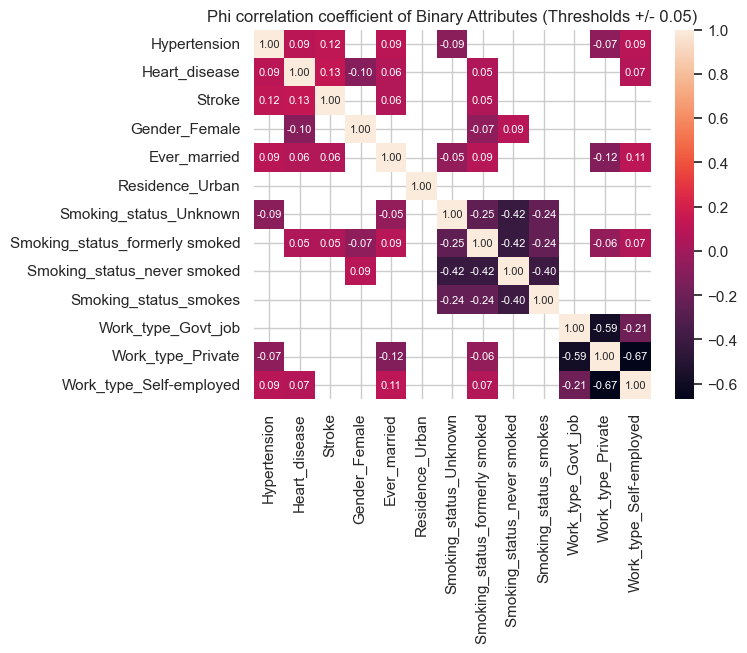

In [73]:
stroke_data_dummies = help_tool.dummy_columns(
    stroke_data, ['Smoking_status', 'Work_type'])

dummy_features = ['Smoking_status_Unknown', 'Smoking_status_formerly smoked',
                  'Smoking_status_never smoked', 'Smoking_status_smokes',
                  'Work_type_Govt_job', 'Work_type_Private', 'Work_type_Self-employed']

help_tool.phi_corr_matrix(stroke_data_dummies, binary_features+dummy_features)

* Binary features are not correlated among each other

## Conclusion:
* Examining data showed that never married people don't have strokes or heart disease, but statistical testing revealed that Stroke and Heart disease happening depends on Age groups. Marriage also depends on age group.
* Target demographic: Married, Female, Works for Private companies, Healthy, Middle aged
* No features are linearly correlated with each other, but age is a factor in a lot of other attributes (marriage, health).
* BMI and Glucose Level are not dependent on age.

# Imputation for missing features.
There's 3 main imputation methods
* Mean/Median/Mode Imputation: Replacing missing values with the Mean/Median/Mode for continuous/ordinal/categorical variables of the observed values in the same column.
* Regression Imputation: Using other variables in the dataset to predict the missing values of a continuous variable. A regression model is built, the predicted values from the regression model are then used to impute the missing values.
* K-Nearest Neighbors (KNN) Imputation.
## BMI and Smoking_status
* Since data is imbalanced and BMI distribution is skewed, KNN imputer was chosen.
* Smoking_status can have ordinal encoding ('never smoked': 0, 'formerly smoked': -1, 'smokes': 1) or mean encoding (mean being the most frequent value 'never smoked'). Ordinal encoding with KNN imputer was chosen for more nuanced imputation.
Missing values will be recorded and entered to the model. 

In [74]:
# Smoking_status
# Ordinal encoding for Smoking_status
stroke_data['Smoking_status'].replace(
    {'Unknown': np.nan, 'never smoked': 0, 'formerly smoked': -1, 'smokes': 1}, inplace=True)

# Imputation with extension
stroke_data['Smoking_status_was_missing'] = stroke_data['Smoking_status'].isnull(
).astype(int)


# BMI
# Imputation with extension for BMI
stroke_data['Bmi_was_missing'] = stroke_data['Bmi'].isnull().astype(int)

Performing KNN imputations.

In [75]:
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])

# Scalling 0 to 1, as KNN is sensitive to neighbor distince

stroke_data_dummies['Age_rescaled'] = stroke_data_dummies['Age']/100

stroke_data_dummies['Avg_glucose_level_rescaled'] = stroke_data_dummies['Avg_glucose_level']/300

stroke_data_dummies['Bmi_rescaled'] = stroke_data_dummies['Bmi']/100


# Removing non-scalled features

def_imputation = stroke_data_dummies.drop(
    ['Bmi', 'Avg_glucose_level', 'Age', 'Bmi_was_missing', 'Smoking_status_was_missing'], axis=1)



# KNNImputer for NaN values

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

imputer.fit(def_imputation)

imputed_features = imputer.transform(def_imputation)

imputed_df = pd.DataFrame(imputed_features, columns=def_imputation.columns)



# Rescalling back BMI

imputed_df['Age'] = imputed_df['Age_rescaled']*100

imputed_df['Avg_glucose_level'] = imputed_df['Avg_glucose_level_rescaled']*300

imputed_df['Bmi'] = imputed_df['Bmi_rescaled']*100

stroke_data_dummies = imputed_df.drop(
    ['Age_rescaled', 'Avg_glucose_level_rescaled', 'Bmi_rescaled'], axis=1)

# Reseting indexes as they got uneven after imputation
imputed_df.reset_index(drop=True, inplace=True)
stroke_data.reset_index(drop=True, inplace=True)

# Assigning new values
stroke_data['Bmi'] = imputed_df['Bmi']
stroke_data['Smoking_status'] = imputed_df['Smoking_status'].round().astype(int)

# Rewriting stroke_data_dummies to fit the new structure
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])

After filling in missing values, feature distribution doesn't look changed.

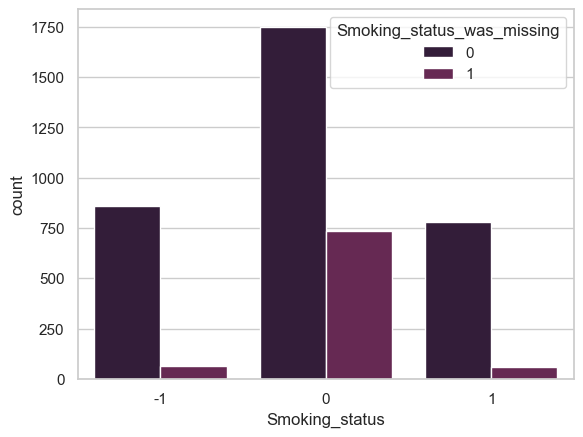

In [76]:
sns.countplot(data=stroke_data, x='Smoking_status',
              hue='Smoking_status_was_missing')
plt.show()

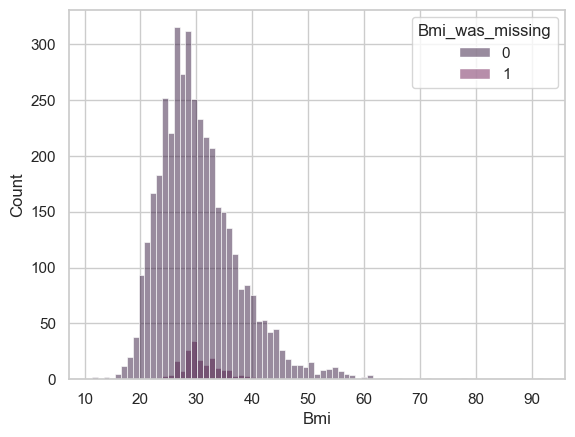

In [77]:
sns.histplot(data=stroke_data, x='Bmi', hue='Bmi_was_missing')
plt.show()

All missing values handled.

In [78]:
stroke_data.isna().sum()

Age                           0
Hypertension                  0
Heart_disease                 0
Work_type                     0
Avg_glucose_level             0
Bmi                           0
Smoking_status                0
Stroke                        0
Bmi_was_missing               0
Gender_Female                 0
Ever_married                  0
Residence_Urban               0
Smoking_status_was_missing    0
dtype: int64

# Categorical and continues features 
Now that all missing values are handled, let's examine the correlation between Categorical and continues features 

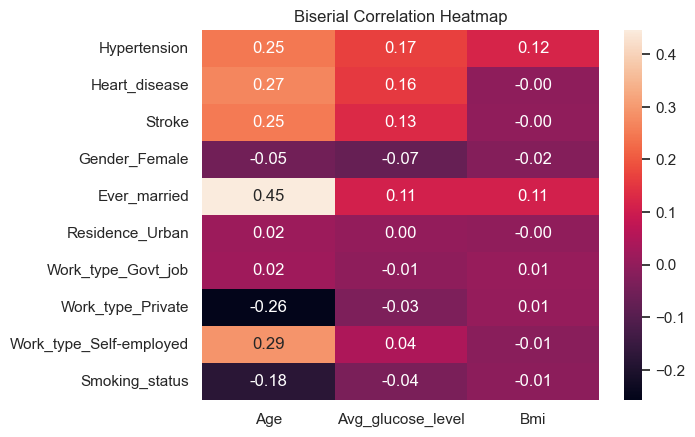

In [79]:
dummy_features = ['Work_type_Govt_job',
                  'Work_type_Private',
                  'Work_type_Self-employed', 'Smoking_status']


correlation_matrix = pd.DataFrame(
    index=binary_features+dummy_features, columns=continues_features)


for binary_feature in binary_features:

    for continuous_feature in continues_features:

        biserial_corr, _ = stats.pointbiserialr(

            stroke_data_dummies[binary_feature], stroke_data_dummies[continuous_feature])

        correlation_matrix.loc[binary_feature,

                               continuous_feature] = biserial_corr


for dummy_feature in dummy_features:

    for continuous_feature in continues_features:

        biserial_corr, _ = stats.pointbiserialr(

            stroke_data_dummies[dummy_feature], stroke_data_dummies[continuous_feature])

        correlation_matrix.loc[dummy_feature,

                               continuous_feature] = biserial_corr


correlation_matrix = correlation_matrix.apply(pd.to_numeric)


sns.heatmap(pd.DataFrame(correlation_matrix),
            annot=True, cmap="rocket", fmt=".2f")

plt.title("Biserial Correlation Heatmap")

plt.show()

Features are not correlated across any continues and binary combination.

## Mutual information
Mutual information gain reveals that by far the most revealing features for Stroke is Age and Heart_diseace. Interestingly, Gender and Residence type does not reduce the uncertainty for Stroke. This could be due to gender and residence having 0/1 values and being distributed among all population types.

In [80]:
stroke_data_rescalled = stroke_data_dummies

stroke_data_rescalled['Age'] = stroke_data_rescalled['Age']/100
stroke_data_rescalled['Avg_glucose_level'] = stroke_data_rescalled['Avg_glucose_level']/300
stroke_data_rescalled['Bmi'] = stroke_data_rescalled['Bmi']/100

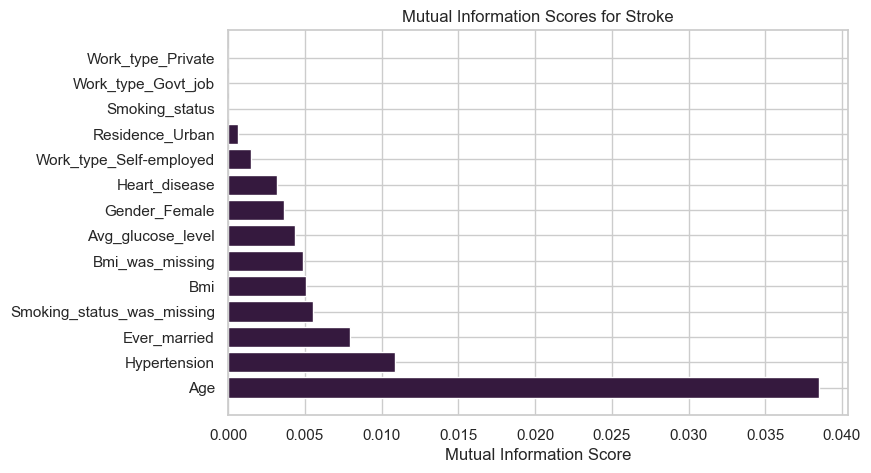

In [81]:
X = stroke_data_rescalled.drop('Stroke', axis=1)
y = stroke_data_rescalled['Stroke']

# Compute mutual information scores
mi_scores = pd.DataFrame(mutual_info_classif(
    X, y), index=X.columns, columns=['Mutual Information Gain'])
mi_scores.sort_values(by='Mutual Information Gain',
                      ascending=False, inplace=True)

# Visualize the scores
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)

plt.figure(dpi=100, figsize=(8, 5))
plt.barh(width, mi_scores['Mutual Information Gain'])
plt.yticks(width, ticks)
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Scores for Stroke")
plt.show()

## Clustering with K-means
K-mean clustering was used for insights on unknown groups from data. Since data has only 3 continues features (but BMI has potentially wrong values), K-mean clustering was used on them 2.

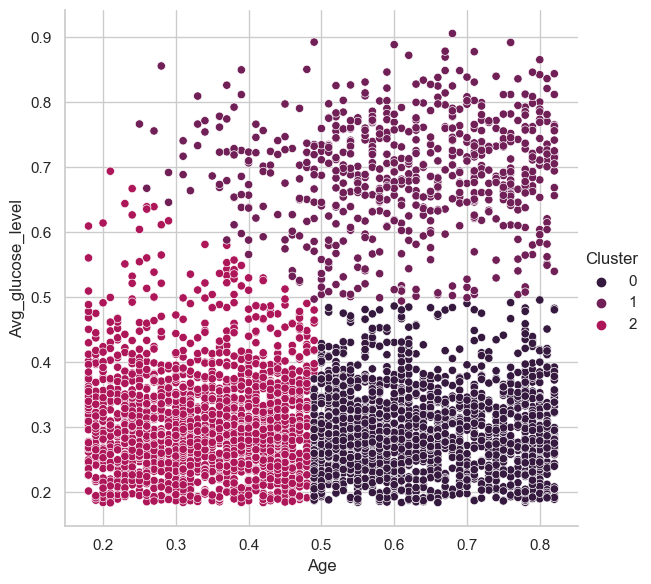

In [82]:
kmeans = KMeans(n_clusters=3, n_init=10)
X["Cluster"] = kmeans.fit_predict(X[['Age', 'Avg_glucose_level']])
X["Cluster"] = X["Cluster"].astype("category")

sns.relplot(data=X, x="Age", y="Avg_glucose_level", hue="Cluster", height=6,)
plt.show()

K-mean clustering was used 'Age', 'Avg_glucose_level'. Created clusters were for age groups and for higher glucose_level.

# Conclusion:

* Data is collected for children and adults, internet research showed that various features (Body Mass Index, Vitamin D) have different levels of safety for children and adults (children's parameters having a hyperbole dependency on the age). This work if focusing only on adults, leaving a dataset of 4248 features. Body Mass Index and Glucose Levels had extremely high values (92 and 272 mg/dL, respectfully). Internet search showed those values being allowed, yet dangerously high. 
* Target demographic: Married, Female, Works for Private companies, Healthy, Middle aged
* No 2 features are strong correlated, no feature pair with linear relationship. 
* BMI and Smoking status was imputed using K-Nearest Neighbors (KNN) Imputation. Although, BMI had missing values related to higher Average Glucose Levels. It could be due to BMI having 2 digits out of maximum 3 (but this theory will be tested in the model development).
* Examining data showed that never married people don't have strokes or heart disease, but statistical testing revealed that Stroke and Heart disease happening depends on Age groups. Marriage also depends on age group.
* Applied mutual information gain showed Age the best predictor of Stroke
* Applied K-means clustering showed pattern for age groups and for higher glucose_level.